# Final challenge: Solving the Gross-Pitaevskii Equation

Parts adapted from https://arxiv.org/pdf/2203.05284.pdf with permission from the authors.

### Background

The [Gross](https://link.springer.com/article/10.1007/BF02731494)-[Pitaevskii](http://jetp.ras.ru/cgi-bin/dn/e_013_02_0451.pdf) (GP) equation (also [here](https://epubs.siam.org/doi/10.1137/20M1313106) for a RBM application) is a nonlinear Schrödinger equation that approximately describes the low-energy properties of dilute Bose-Einstein condensates. Using a self-consistent mean field approximation, the many-body wavefunction is reduced to a description in terms of a single complex-valued wavefunction $\phi(\vec{r})$. We work with the [one-dimensional Gross-Pitaevskii equation](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.62.063610) with a harmonic trapping potential by letting $F_\alpha$ be:

\begin{equation}
  F_{q,\kappa}(\phi)= -\phi''+\kappa x^2\phi+q|\phi|^2\phi-\lambda_{q,\kappa}\phi=0,
\end{equation}
where the parameters are now $\alpha=\{\kappa, q\}$, which are proportional to the strength of the harmonic trapping and the self-coupling of the wavefunction,respectively, while $\lambda_{q,\kappa}$ is proportional to the ground state energ. $\phi(x)$ is a single variable function that depends on $x$ and it is normalized to unity.

To be able to solve this problem in a quantum computer with few qbits we follow the same procedure as with the Harmonic Oscillator problem and cast the equations in the reduced basis. We once again expand our solution in a basis of $n$ elements:
\begin{align}
\hat{\phi}_{\alpha}(x) = \sum_{i=1}^{n} a_{i} \phi_{i}(x) 
\end{align}
where $\phi_{i}(x)$ are informed on previous solutions built on a classical computer to the non-linear Schrodinger equation for chosen values of $\alpha=\{\kappa,q\}$. 

The main challenge now resides in the fact that we can't write $F_{\alpha}$ in terms of linear operators since the "Hamiltonian" is dependent on the actual solution $\phi(x)$: $H_\alpha \equiv H_\alpha[\phi]=(-\frac{d^2}{dx^2}+\kappa x^2 +q|\phi|^2)$. The Galerkin projection equations are general enough that this problem can be [tackled directly](https://arxiv.org/pdf/2203.05284.pdf), which leads to a series of non-linear equations (up to fourth powers) in the unknown coefficients $a_i$ and the approximated eigenvalue $\hat\lambda$. 

In order to tackle this problem in a quantum circuit with the machinery we have developed up to this point we propose an approach that allows one to avoid having to solve a non-linear problem by instead solving a linear one many times in an iteratively scheme. This is the approach frequently used in many Density Functional Theory implementations [CITE]. We make a guess, which we call $\phi_0$, on the solution of the original non-linear problem. We now iteratively find the solution $\phi_{n}$ to a linear Schrodinger equation with Hamiltonian $H_\alpha[\phi_{n-1}]$. If the original guess $\phi_0$ was close enough to the true solution, then with enough iterations we should reach self consistency and obtain a wave function such that $F_\alpha [\phi]= H_\alpha[\phi]\phi -\lambda \phi=0$. 

In the following we implement this iterative approach to solve the GP equation first in a classical computer, using a basis with two states. We then proceed to design solution for a quantum computer.

In [7]:
import numpy as np
import scipy as sci
from scipy import optimize
from scipy import special
import matplotlib.pyplot as plt

In [8]:
### NOTE: hbar = 1 in this demo

def V(x,kappa):
    '''
    1-d harmonic Oscillator potential

    Parameters
    ----------
    x : float or nd array
        position.
    alpha : float
        oscillator length parameter.

    Returns
    -------
    float or ndarray
        value of potential evaluated at x.

    '''
    return kappa*x**2


 

def construct_H(grid,mass,kappa,q,PHIgrid):
   #PHIgrid is the value of the guess for the nonlinear part at each location
    dim = len(grid)
    off_diag = np.zeros(dim)
    off_diag[1] = 1
    H = -1*(-2*np.identity(dim) + sci.linalg.toeplitz(off_diag))/(mass*h**2) + np.diag(V(grid,kappa))+ q*np.diag(PHIgrid**2)
    
    return H




In [22]:
#First define global variables
h =  1*10**(-1) ### grid spacing for domain (Warning around 10**(-3) it starts to get slow).
### HO global parameters 
n = 0 # principle quantum number to solve in HO
mass = 1.0 # mass for the HO system
# define the domain boundaries
x_a = -10 # left boundary 
x_b = 10 # right boundary 
x_array = np.arange(x_a,x_b+h,h)
m = len(x_array) 
print('Number of grid points: ',m)


def solve(H,grid,h):
    '''
    Parameters
    ----------
    H : 2d ndarray
        Hamiltonian Matrix.
    grid : ndarray
        Discretized 1d domain.
    h : float
        grid spacing.

    Returns
    -------
    evals : ndarray
        returns nd array of eigenvalues of H. 
    evects : ndarray
        returns ndarray of eigenvectors of H.
    Eigenvalues and eigenvectors are ordered in ascending order. 
    '''
    evals,evects = np.linalg.eigh(H)
    evects = evects.T
    for i,evect in enumerate(evects):
        #norm = np.sqrt(1/sci.integrate.simpson(evect*evect,grid))
        norm = 1/(np.linalg.norm(evect))  #We need to check these normalizations in the other jupyter book!
        evects[i] = evects[i]*norm/np.sqrt(h)
    return evals,evects


def IterativeSolver(grid,q,kappa,maxIterations):
    Hn = construct_H(grid,1,kappa,0,np.zeros(len(x_array))) # First Hamiltonian with the q interaction put to zero
    PHIn=solve(Hn,grid,h)[1][0]
    ListOfPhiOlds=[np.copy(PHIn),np.copy(PHIn),np.copy(PHIn),np.copy(PHIn),np.copy(PHIn),np.copy(PHIn)]
    
    for IJ in range(maxIterations):
        if IJ<maxIterations/2:
            qeff=q*(IJ/maxIterations)*2
        else:
            qeff=q
        Hn=construct_H(grid,1,kappa,qeff,(ListOfPhiOlds[-1]+ListOfPhiOlds[-2]+ListOfPhiOlds[-3]+ListOfPhiOlds[-4]+ListOfPhiOlds[-5]+ListOfPhiOlds[-6])/6.0)
        SOL=solve(Hn,grid,h)
        
        PHIn=SOL[1][0]
        ListOfPhiOlds.append(np.copy(PHIn))
        
        
            
    # print("max iterations:" ,IJ) 
    # return ListOfPhiOlds
    return SOL
    
    




def getSystem(H,psi_array,phi_array):
    '''
    Sets up syetem of equations for Galerkin projection <\phi_{j},F_{k}(phi_{k})>

    Parameters
    ----------
    H : ndarray
        Hamiltonian matrix.
    psi_array : ndarray
        array of projector functions. Assumes rows are corresponding to discretized functions
    phi_array : TYPE
        DESCRIPTION.

    Returns
    -------
    Function
        Function that takes in a vector of parameters of the form (a_{1},a_{2},....,\lambda_{\alpha}) 
        and outputs of the system of equations. \lambda_{\alpha} is the eigenvalue of HO equation.
    '''
    ## 
    def system(a_vec):
        '''
        Parameters
        ----------
        a_vec : ndarray
            vector of parameters (a_{k},\lambda).

        Returns
        -------
        results : ndarray
            outputs of the Galerkin projection equations and normalization functions <\hat{\phi}|\hat{\phi}> = 1.
            This systems can be solved using sci.optimize.fsolve or using your choice of method.
        '''
        results = np.zeros(len(a_vec))
        results[-1] = -1 # from normalization
        for i in np.arange(0,len(a_vec)-1,1):
            for k in np.arange(0,len(a_vec)-1,1):
                results[i] += a_vec[k]*np.dot(psi_array[i],np.matmul(H,phi_array[k])) - \
                a_vec[-1]*a_vec[k]*np.dot(psi_array[i],phi_array[k])
        for k in np.arange(0,len(a_vec)-1,1):
            for kp in np.arange(0,len(a_vec)-1,1):
                results[-1] += a_vec[kp]*a_vec[k]*np.dot(psi_array[kp],phi_array[k])
        return results
    return system

    


Number of grid points:  201


In [23]:
# #First define global variables
# h = 5*10**(-2) ### grid spacing for domain (Warning around 10**(-3) it starts to get slow).
# ### HO global parameters 
# n = 0 # principle quantum number to solve in HO
# mass = 1.0 # mass for the HO system
# # define the domain boundaries
# x_a = -10 # left boundary 
# x_b = 10 # right boundary 
# x_array = np.arange(x_a,x_b+h,h)
# m = len(x_array) 
# print('Number of grid points: ',m)


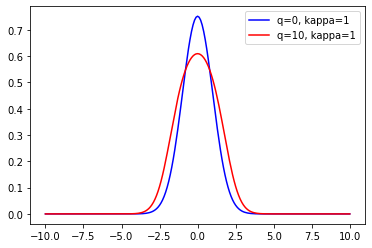

4.022841278511245


In [24]:
solution0=IterativeSolver(x_array,0,1,1)
solution=IterativeSolver(x_array,10,1,1000)


plt.plot(x_array, solution0[1][0], color="blue",label = 'q=0, kappa=1')
plt.plot(x_array, abs(solution[1][0]), color="red",label = 'q=10, kappa=1')
plt.legend()
plt.show()
print(solution[0][0])

First select a set of values of $\alpha$ to solve the SE with. These solutions will be used as the basis in the reduced basis model.

In [25]:
# Select alpha values to use to solve SE exactly.
alpha_vals = [[0,1],[1,1],[0,2],[5,1],[10,1]]  #[q,kappa] Here, we choose 5 values of alpha to solve exactly. This results in 3 basis functions
# initialize solution arrays. T is the matrix that will hold wavefunction solutions. 
# T has the form T[i][j], i = alpha, j = solution components
T = np.zeros((len(alpha_vals),m)) 
# T_evals holds the eigenvalues for each evect in T. 
T_evals = np.zeros(len(alpha_vals))

alpha = [0, 1], lambda = 0.9993746086405191
alpha = [1, 1], lambda = 1.3830689347074987
alpha = [0, 2], lambda = 1.4129624545775832
alpha = [5, 1], lambda = 2.6896595245510793
alpha = [10, 1], lambda = 4.022841278511271


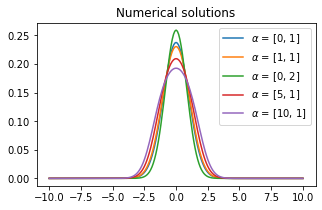

In [26]:
for i,alpha_sample in enumerate(alpha_vals):
    
    evals, evects = IterativeSolver(x_array,alpha_sample[0],alpha_sample[1],700) # solve the system for evals and evects.
    T[i] = evects[n]/np.linalg.norm(evects[n]) # assign the nth evect to solution array T
    T_evals[i] = evals[n] # assign the nth eigenvalue to the eigenvalue array T_eval.
    print(f'alpha = {alpha_sample}, lambda = {evals[n]}')
    

    

# Make plots of the numerical wavefunction 
fig, ax = plt.subplots(1,1,figsize=(5,3))
for i in range(len(alpha_vals)):
    
    ax.plot(x_array,(T[i]),label=r'$\alpha$ = '+str(alpha_vals[i]))

ax.set_title('Numerical solutions')

ax.legend()

plt.show()



### Creating an orthonormal basis of two elements and checking that our problem is well behaved (fast decay in singular values)

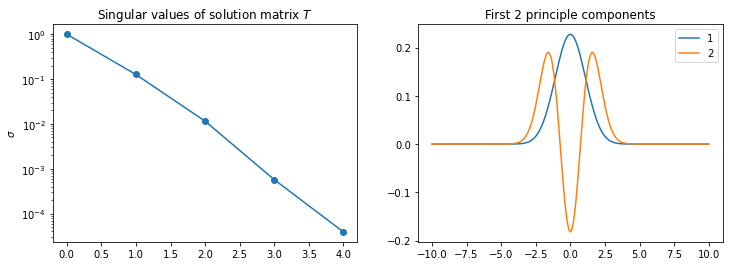

In [27]:
U, s, Vh = np.linalg.svd(T)
phi1=-1*Vh[0] #multiplying by -1 so they are positive at x=0, not necessary but the plots look better
phi2=1*Vh[1]
n_comps = 2 # number of principle components to plot (i.e number of column vectors of SVD matrix V to plot)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].semilogy(s/s[0],'o-')
ax[0].set_title(r'Singular values of solution matrix $T$')
ax[0].set_ylabel(r'$\sigma$')

ax[1].plot(x_array,phi1,label=str(1))
ax[1].plot(x_array,phi2,label=str(2))
ax[1].set_title(f'First {n_comps} principle components')
ax[1].legend()
plt.show()


### We will now model an effective hamiltonian in which two "particles" interact, each one represents one of these two components.

This discussion retraces everything we did before for the Harmonic Oscillator. The main difference is that now the Hamiltonian effectively depends on the solution $H_\alpha \equiv H_\alpha[\phi]$, but since we are aiming at solving the problem iteratively, at each stage we have a fixed linear Hamiltonian.

Here we explicitly construct $ \hat{\phi}_{\alpha}= a_{1} \phi_{1}+a_2\phi_2$ and use the Galerkin method, that is, projecting $F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big)$ over $2$ linearly independent functions projecting functions $\{ \psi_{i}\}_{i=1}^{2}$. 

\begin{align}
&\langle \psi{1}| F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big) \rangle = 0 \\
&\langle \psi{2}| F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big) \rangle = 0 
\end{align}

We can interpret this as enforcing the orthogonality of $F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big)$ to the subspace spanned by $\{\psi_{i}\}$ that is, by finding $\hat{\phi}_{\alpha}$ such that $F_{\alpha}(\hat{\phi}_{\alpha})$ is approximately zero up to the ability of the set $\{\psi_{i}\}$. The choice of projecting functions $\{ \psi_{i} \}$ is arbitrary, but here we choose the solution set $\{ \phi_{i} \}$ to be our projecting functions to make our lives easier. Since $\lambda$ is also unknown, we need an additional equation. This comes from the normalization conditions:

\begin{align}
\langle \hat{\phi}_{\alpha_{k}}|\hat{\phi}_{\alpha_{k}} \rangle  = 1
\end{align}

We can re-write the projecting equations taking advantage of the linear form of $F_\alpha$ to obtain an effective 2-level system Hamiltonian. We note that:

\begin{align}
&\langle \phi_{i}| F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big) \rangle =  \\
&\langle \phi_{i}|  a_1 H_\alpha \phi_1 + a_2 H_\alpha \phi_2 - a_1\hat \lambda \phi_1 - a_2\hat \lambda \phi_2\rangle
\end{align}

Since $\langle \phi_i|\phi_j\rangle = \delta _{i,j}$, we arrive at the following matrix equation for the projecting equations:

\begin{equation}
\tilde H_\alpha |a\rangle = \hat\lambda |a\rangle
\end{equation}

where $|a\rangle = \{a_1,a_2\}$ and 

\begin{equation}
\tilde H_\alpha = \begin{bmatrix} \langle \phi_1|H_\alpha|\phi_1\rangle & \langle \phi_1|H_\alpha|\phi_2\rangle \\ \langle \phi_2|H_\alpha|\phi_1\rangle & \langle \phi_2|H_\alpha|\phi_2\rangle \end{bmatrix}
\end{equation}

while the normalization condition translates into:

\begin{equation}
\langle a|a \rangle  = a_1^2+a_2^2= 1
\end{equation}


Now we proceed to construct this Hamiltonian matrix for our problem at hand. We note that although $\tilde H_\alpha$ depennds on $\alpha$, the dependance is only in the tow potential parts and it is affine (linear): $H_\alpha=H_0+\kappa H_1 +q H_2$, where $H_0= - \frac{d^{2}}{dx^{2}}$, $H_1= x^2$, and $H_2=|\phi(x)|^2$. We then decompose $\tilde H_\alpha= \tilde H_0 + \kappa \tilde H_1+ q \tilde H_2$. We now construct these matrices, $H_2$ being a function that must be constructed every time:

In [28]:
dim0 = len(x_array)
off_diag = np.zeros(dim0)
off_diag[1] = 1

H0=-1*(-2*np.identity(dim0) + sci.linalg.toeplitz(off_diag))/(mass*h**2) 
H1=np.diag(V(x_array,1))

tildeH0=np.array([[0.0,0.0],[0.0,0.0]])
tildeH1=np.array([[0.0,0.0],[0.0,0.0]])

tildeH0[0][0]=np.dot(phi1,np.dot(H0,phi1))
tildeH0[0][1]=np.dot(phi1,np.dot(H0,phi2))
tildeH0[1][0]=np.dot(phi2,np.dot(H0,phi1))
tildeH0[1][1]=np.dot(phi2,np.dot(H0,phi2))

tildeH1[0][0]=np.dot(phi1,np.dot(H1,phi1))
tildeH1[0][1]=np.dot(phi1,np.dot(H1,phi2))
tildeH1[1][0]=np.dot(phi2,np.dot(H1,phi1))
tildeH1[1][1]=np.dot(phi2,np.dot(H1,phi2))

H2_11=np.diag(phi1**2)
H2_12=np.diag(phi1*phi2)
H2_22=np.diag(phi2**2)

tildeH2_11=np.array([[0.0,0.0],[0.0,0.0]])
tildeH2_11[0][0]=np.dot(phi1,np.dot(H2_11,phi1))
tildeH2_11[0][1]=np.dot(phi1,np.dot(H2_11,phi2))
tildeH2_11[1][0]=np.dot(phi2,np.dot(H2_11,phi1))
tildeH2_11[1][1]=np.dot(phi2,np.dot(H2_11,phi2))




tildeH2_12=np.array([[0.0,0.0],[0.0,0.0]])
tildeH2_12[0][0]=np.dot(phi1,np.dot(H2_12,phi1))
tildeH2_12[0][1]=np.dot(phi1,np.dot(H2_12,phi2))
tildeH2_12[1][0]=np.dot(phi2,np.dot(H2_12,phi1))
tildeH2_12[1][1]=np.dot(phi2,np.dot(H2_12,phi2))


tildeH2_22=np.array([[0.0,0.0],[0.0,0.0]])
tildeH2_22[0][0]=np.dot(phi1,np.dot(H2_22,phi1))
tildeH2_22[0][1]=np.dot(phi1,np.dot(H2_22,phi2))
tildeH2_22[1][0]=np.dot(phi2,np.dot(H2_22,phi1))
tildeH2_22[1][1]=np.dot(phi2,np.dot(H2_22,phi2))

def tildeH2(coeffs):
    # H2=np.diag(PHIList**2)
    
    
    # tildeH2=np.array([[0.0,0.0],[0.0,0.0]])

    # tildeH2[0][0]=np.dot(phi1,np.dot(H2,phi1))
    # tildeH2[0][1]=np.dot(phi1,np.dot(H2,phi2))
    # tildeH2[1][0]=np.dot(phi2,np.dot(H2,phi1))
    # tildeH2[1][1]=np.dot(phi2,np.dot(H2,phi2))
    # return tildeH2


    return (coeffs[0]**2*tildeH2_11+2*coeffs[0]*coeffs[1]*tildeH2_12+coeffs[1]**2*tildeH2_22)/h
    



print('H0=', tildeH0)
print('H1=',tildeH1)

print('H2=',tildeH2([1,0]))


H0= [[ 0.42023097 -0.58365092]
 [-0.58365092  2.61560759]]
H1= [[0.59436083 0.82835933]
 [0.82835933 2.3627665 ]]
H2= [[ 0.36584365 -0.13715205]
 [-0.13715205  0.16958109]]


In [96]:
def tildeH(alpha,coeffs):
    return tildeH0+alpha[1]*tildeH1+alpha[0]*tildeH2(coeffs)

def systemSolver(alpha,coeffs):
    resultssystem= np.linalg.eig(tildeH(alpha,coeffs))
    # if resultssystem[1][0][0]<0:
    #     resultssystem[1][0]=resultssystem[1][0]*(-1)
    # if resultssystem[1][1][0]<0:
    #     resultssystem[1][1]=resultssystem[1][1]*(-1)   
    return [resultssystem[0],np.transpose(resultssystem[1])]

def phibuilderFromCoeffs(coefficients):
    coefficients0=[coefficients[0]/(np.linalg.norm(coefficients))/np.sqrt(h),coefficients[1]/(np.linalg.norm(coefficients))/np.sqrt(h)]
    return coefficients0[0]*phi1+coefficients0[1]*phi2

def ItetariveRBMsolver(alpha,maxIterations):
    sol0=systemSolver([0,alpha[1]],[1,0])
    # sol0=systemSolver([alpha[0],alpha[1]],[0.9913,0.131144])
    
    ListOfPhiOlds=[np.copy(sol0[1][0]),np.copy(sol0[1][0]),np.copy(sol0[1][0]),np.copy(sol0[1][0]),np.copy(sol0[1][0]),np.copy(sol0[1][0])]
    for IJ in range(maxIterations):
        if IJ<maxIterations/2:
        # if IJ<0:
            qeff=alpha[0]*(IJ/maxIterations)*2
        else:
            qeff=alpha[0]
        
        sol0=systemSolver([qeff,alpha[1]],  
        (ListOfPhiOlds[-1]+ListOfPhiOlds[-2]+ListOfPhiOlds[-3]+ListOfPhiOlds[-4]+ListOfPhiOlds[-5]+ListOfPhiOlds[-6])/6.0
        )


        ListOfPhiOlds.append(np.copy(sol0[1][0]))
    return sol0




In [99]:
print(ItetariveRBMsolver([7,1],1000))

[array([3.25022029, 6.2374432 ]), array([[-0.9913355 , -0.13135421],
       [ 0.13135421, -0.9913355 ]])]


Now we try our solution solver against the finite element computation:

In [100]:
# Now we can construct our RBM for an alpha of our choosing. 
alpha_k = [7,1]
solFinite=IterativeSolver(x_array,alpha_k[0],alpha_k[1],1000)[1][0]

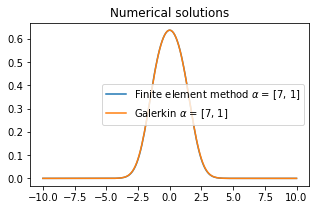

In [103]:

solFull=ItetariveRBMsolver(alpha_k,1000)
solGaler=phibuilderFromCoeffs(solFull[1][0])
lamGaler=solFull[0][0]


    

# Make plots of the numerical wavefunction 
fig, ax = plt.subplots(1,1,figsize=(5,3))


ax.plot(x_array,solFinite,label=r'Finite element method $\alpha$ = '+str(alpha_k))
ax.plot(x_array,-solGaler,label= r'Galerkin $\alpha$ = '+str(alpha_k))

ax.set_title('Numerical solutions')

ax.legend()

plt.show()

